<a href="https://colab.research.google.com/github/WilliamVoster/predictHousePricesTeamProject/blob/master/HousePricePredictionTeamProject(3rdTimesTheCharm).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Implementing XGBoost

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import seaborn as sns
import statistics
import math

## annoying error handling :(
pd.options.mode.chained_assignment = None

train   = pd.read_csv("https://raw.githubusercontent.com/WilliamVoster/predictHousePricesTeamProject/master/house-prices-advanced-regression-techniques/train.csv")
test    = pd.read_csv("https://raw.githubusercontent.com/WilliamVoster/predictHousePricesTeamProject/master/house-prices-advanced-regression-techniques/test.csv")
sample  = pd.read_csv("https://raw.githubusercontent.com/WilliamVoster/predictHousePricesTeamProject/master/house-prices-advanced-regression-techniques/sample_submission.csv")

In [0]:
# Combining all the tables into one!
b = [i for i in sample["SalePrice"].tolist()]
a = pd.DataFrame({"SalePrice": b}, index=sample["Id"].tolist())
d = [i for i in test["Id"]]
test.index = d
testWithSalePrice = pd.concat([test, a], axis=1, sort=False)
fullData = pd.concat([train, testWithSalePrice], sort=False)

In [0]:
fullData

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706.0,Unf,0.0,150.0,856.0,GasA,...,Y,SBrkr,856,854,0,1710,1.0,0.0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2.0,548.0,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500.000000
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978.0,Unf,0.0,284.0,1262.0,GasA,...,Y,SBrkr,1262,0,0,1262,0.0,1.0,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2.0,460.0,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500.000000
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486.0,Unf,0.0,434.0,920.0,GasA,...,Y,SBrkr,920,866,0,1786,1.0,0.0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2.0,608.0,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500.000000
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216.0,Unf,0.0,540.0,756.0,GasA,...,Y,SBrkr,961,756,0,1717,1.0,0.0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3.0,642.0,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000.000000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655.0,Unf,0.0,490.0,1145.0,GasA,...,Y,SBrkr,1145,1053,0,2198,1.0,0.0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3.0,836.0,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2915,2915,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,Twnhs,2Story,4,7,1970,1970,Gable,CompShg,CemntBd,CmentBd,None,0.0,TA,TA,CBlock,TA,TA,No,Unf,0.0,Unf,0.0,546.0,546.0,GasA,...,Y,SBrkr,546,546,0,1092,0.0,0.0,1,1,3,1,TA,5,Typ,0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal,167081.220949
2916,2916,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,TwnhsE,2Story,4,5,1970,1970,Gable,CompShg,CemntBd,CmentBd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,252.0,Unf,0.0,294.0,546.0,GasA,...,Y,SBrkr,546,546,0,1092,0.0,0.0,1,1,3,1,TA,6,Typ,0,NaN,CarPort,1970.0,Unf,1.0,286.0,TA,TA,Y,0,24,0,0,0,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml,164788.778231
2917,2917,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1Story,5,7,1960,1996,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,ALQ,1224.0,Unf,0.0,0.0,1224.0,GasA,...,Y,SBrkr,1224,0,0,1224,1.0,0.0,1,0,4,1,TA,7,Typ,1,TA,Detchd,1960.0,Unf,2.0,576.0,TA,TA,Y,474,0,0,0,0,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml,219222.423400
2918,2918,85,

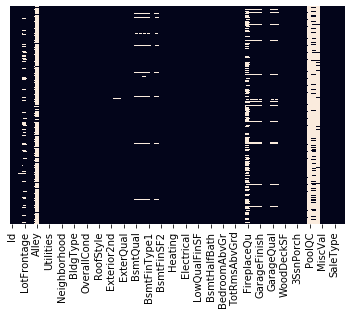

In [0]:
sns.heatmap(fullData.isnull(),yticklabels=False,cbar=False)

In [0]:
fullData = fullData.drop(labels="Alley", axis="columns")
fullData = fullData.drop(labels="Fence", axis="columns")
fullData = fullData.drop(labels="FireplaceQu", axis="columns")
fullData = fullData.drop(labels="PoolQC", axis="columns")
fullData = fullData.drop(labels="PoolArea", axis="columns")
fullData = fullData.drop(labels="MiscFeature", axis="columns")

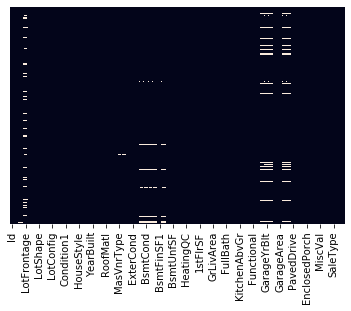

In [0]:
sns.heatmap(fullData.isnull(),yticklabels=False,cbar=False)

In [0]:
fullData.isnull().sum().sum()

1753

In [0]:
type1 = ""
type2 = ""
for i in fullData.columns:
  dataType = type(fullData[i][0])
  
  if type1 != dataType:
      type1 = dataType
  else:
    type2 = dataType

print(type1, type2)

type1Arr = []
type2Arr = []

for i in fullData.columns:
  nanVals = fullData[i].isnull().sum()
  dataType = type(fullData[i][0])
  
  if nanVals > 0 :
    print(i, "\t", nanVals, "\t", dataType)

    if dataType == type1:
      type1Arr.append(i)
    if dataType == type2:
      type2Arr.append(i)
    
print(type1, type1Arr)
print(type2, type2Arr)

<class 'numpy.float64'> <class 'str'>
MSZoning 	 4 	 <class 'str'>
LotFrontage 	 486 	 <class 'numpy.float64'>
Utilities 	 2 	 <class 'str'>
Exterior1st 	 1 	 <class 'str'>
Exterior2nd 	 1 	 <class 'str'>
MasVnrType 	 24 	 <class 'str'>
MasVnrArea 	 23 	 <class 'numpy.float64'>
BsmtQual 	 81 	 <class 'str'>
BsmtCond 	 82 	 <class 'str'>
BsmtExposure 	 82 	 <class 'str'>
BsmtFinType1 	 79 	 <class 'str'>
BsmtFinSF1 	 1 	 <class 'numpy.float64'>
BsmtFinType2 	 80 	 <class 'str'>
BsmtFinSF2 	 1 	 <class 'numpy.float64'>
BsmtUnfSF 	 1 	 <class 'numpy.float64'>
TotalBsmtSF 	 1 	 <class 'numpy.float64'>
Electrical 	 1 	 <class 'str'>
BsmtFullBath 	 2 	 <class 'numpy.float64'>
BsmtHalfBath 	 2 	 <class 'numpy.float64'>
KitchenQual 	 1 	 <class 'str'>
Functional 	 2 	 <class 'str'>
GarageType 	 157 	 <class 'str'>
GarageYrBlt 	 159 	 <class 'numpy.float64'>
GarageFinish 	 159 	 <class 'str'>
GarageCars 	 1 	 <class 'numpy.float64'>
GarageArea 	 1 	 <class 'numpy.float64'>
GarageQual 	 159 	 <c

In [0]:
fullData.reset_index(drop=True, inplace=True)

In [0]:
tempCol = ""
arrOfIdsToRemove = [None] * len(type1Arr)
for i in range(len(type1Arr)):
  tempCol = fullData[type1Arr[i]].isnull()
  #print(i)
  arrOfIdsToRemove[i] = []
  tempMean = fullData[type1Arr[i]].mean()
  for j in range(len(fullData[type1Arr[i]])):
    if tempCol[j]:
      #print(j, tempCol[j], fullData[type1Arr[i]][j], fullData[type1Arr[i]].mean())
      fullData[type1Arr[i]][j] = tempMean
      arrOfIdsToRemove[i].append(j)


In [0]:
r = []
tempCol = ""
arrOfIdsToRemove = [None] * len(type2Arr)
for i in range(len(type2Arr)):
  tempCol = fullData[type2Arr[i]].isnull()
  arrOfIdsToRemove[i] = []
  tempMode = statistics.mode(fullData[type2Arr[i]])
  for k in fullData[type2Arr[i]]:
    r.append(k)
  for j in range(len(fullData[type2Arr[i]])):
    if tempCol[j]:
      #print(j, fullData[type2Arr[i]], tempCol[j], fullData[type2Arr[i]][j])#, fullData[type2Arr[i]].mode())
      fullData[type2Arr[i]][j] = tempMode
      arrOfIdsToRemove[i].append(j)

In [0]:
fullData.isnull().sum().sum()

0

#NO MORE MISSING VALUES!

In [0]:
listOfNumericAttributes = ["MSSubClass", "LotFrontage", "LotArea", "OverallQual", "OverallCond", "MasVnrArea", "BsmtFinSF1", "BsmtFinSF2", "BsmtUnfSF", "TotalBsmtSF", "1stFlrSF", "2ndFlrSF", "LowQualFinSF", "GrLivArea", "BsmtFullBath", "BsmtHalfBath", "FullBath", "HalfBath", "BedroomAbvGr", "BedroomAbvGr", "TotRmsAbvGrd", "Fireplaces", "GarageYrBlt", "GarageCars", "GarageArea", "WoodDeckSF", "OpenPorchSF", "EnclosedPorch", "3SsnPorch", "ScreenPorch", "PoolArea", "MiscVal", "MoSold", "YrSold", "SalePrice"]
categoricalAttributes = []
for x in fullData.columns:
  if x not in listOfNumericAttributes and x != "Id":
    categoricalAttributes.append(x)
#print(categoricalAttributes)
#fullData[categoricalAttributes]

In [0]:
fullData = pd.get_dummies(fullData)#, prefix=["test"]*(len(fullData.columns)))

In [0]:
# function is not being used

def categoricalDummyColumns(cols):
  returnDataframe = fullData[::]
  #print(returnDataframe)

  for row in cols:
    #print(row)
    dummyDataframe = pd.get_dummies(returnDataframe[row], prefix=[row]*(len(row)-1))
    returnDataframe.drop([row], axis=1, inplace=True)
    #print(dummyDataframe)
    returnDataframe = pd.concat([returnDataframe, dummyDataframe], axis=1)

  return returnDataframe

#fullData = categoricalDummyColumns(categoricalAttributes)



##handeled string/categories

In [0]:
# 70 30 ratio of train and test

numTrain = math.floor(len(fullData) * 0.7)
numTest = len(fullData) - numTrain

print(numTrain, numTest)

2043 876


In [0]:
trainData = fullData.iloc[:numTrain]
testData = fullData.iloc[:numTest]
print(trainData.shape, testData.shape)

(2043, 271) (876, 271)


In [0]:
testData = testData.drop(labels="SalePrice", axis=1)

##Data is split into train and test

In [0]:
#X["SaleCondition_Partial"] = [True] * (len(X.index))

In [0]:
# salePriceOfTrainData = trainData.drop(['SalePrice'],axis=1)
# trainData = trainData.drop(['SalePrice'],axis=1)

In [0]:

X = trainData[[x for x in trainData.columns]]
X.drop(['SalePrice'],axis=1,inplace=True)
y = trainData["SalePrice"]

In [0]:
print(len(fullData.columns))
print(len(trainData.columns))
print(len(X.columns))
([x for x in trainData.columns] == [x for x in fullData.columns])
#[x for x in X.columns]
#y

271
271
270


True

In [0]:
model = xgb.XGBRegressor()
model.fit(X, y)

[23:52:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [0]:
yPredictions = model.predict(testData)
print(len(yPredictions))
print(len(testData))
#testData

876
876


In [0]:
#submissionPredictions = model.predict()

In [0]:
# data_dmatrix = xgb.DMatrix(data=X, label=y)

## Got predictions without changing hyper parameters

In [0]:
dataToPredict = fullData.iloc[1460:2919]
dataToPredict.drop(['SalePrice'],axis=1,inplace=True)

In [0]:
X_submission = fullData.iloc[0:1460]

In [0]:
X_submission.drop(['SalePrice'],axis=1,inplace=True)
y_submission = fullData["SalePrice"].iloc[0:1460]

In [0]:
model_submission = xgb.XGBRegressor()
model_submission.fit(X_submission, y_submission)

[23:52:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [0]:
yPredictions = model_submission.predict(dataToPredict)

In [0]:
output = pd.DataFrame({'Id': range(1461, 2920),
                       'SalePrice': yPredictions})
output.to_csv('huh.csv', index=False)
print(output)

        Id      SalePrice
0     1461  119592.359375
1     1462  157001.828125
2     1463  174440.812500
3     1464  180708.968750
4     1465  190786.625000
...    ...            ...
1454  2915   80355.242188
1455  2916   86393.265625
1456  2917  158511.859375
1457  2918  121184.421875
1458  2919  235211.578125

[1459 rows x 2 columns]
